In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
from   matplotlib import pyplot as plt
from   scipy.integrate import odeint as ode
%matplotlib inline

In [2]:
def TwoBody(state,t,params):
    #unpack the state
    x     = state[0]
    y     = state[1]
    z     = state[2]
    vx    = state[3]
    vy    = state[4]
    vz    = state[5]
    
    #unpack params
    alpha = params['alpha']
    
    #define helpers
    r     = sp.sqrt(x**2 + y**2 + z**2)
    q     = alpha/r**3
    
    #state derive
    ds = [vx, vy, vz, -q*x, -q*y, -q*z]
    return ds

In [3]:
def Debye(state,t,params):
    #unpack the state
    x     = state[0]
    y     = state[1]
    z     = state[2]
    vx    = state[3]
    vy    = state[4]
    vz    = state[5]
    
    #unpack params
    alpha = params['alpha']
    R     = params['R']
    
    #define helpers
    r     = sp.sqrt(x**2 + y**2 + z**2)
    q     = alpha*(r+R)*sp.exp(-r/R)/r**3/R
    
    #state derive
    ds = [vx, vy, vz, -q*x, -q*y, -q*z]
    return ds

In [4]:
def TwoBody_conserved_quantities(soln,params):
    pos     = soln[:,0:3]
    vel     = soln[:,3:6]
    r       = np.sqrt((pos*pos).sum(axis=1)).reshape(-1,1) #makes the broadcast shape correct???
    E       = 0.5*(vel*vel).sum(axis=1).reshape(-1,1) - params['alpha']/r #other reshape needed to avoid a NxN shape for E???
    L       = np.cross(pos,vel)
    Ecc     = np.cross(vel,L)/params['alpha'] -  pos/r
    return E, L, Ecc    

In [5]:
def Debye_conserved_quantities(soln,params):
    pos     = soln[:,0:3]
    vel     = soln[:,3:6]
    r       = np.sqrt((pos*pos).sum(axis=1)).reshape(-1,1) #makes the broadcast shape correct???
    E       = 0.5*(vel*vel).sum(axis=1).reshape(-1,1) - params['alpha']*sp.exp(-r/params['R'])/r #other reshape needed to avoid a NxN shape for E???
    L       = np.cross(pos,vel)
    Ecc     = np.cross(vel,L)/params['alpha'] -  pos/r
    return E, L, Ecc    

In [6]:
def scattering_angle(soln):
    vi     = soln[0,3:6]
    vf     = soln[max(soln.shape)-1,3:6]
    vi_mag = sp.sqrt( vi[0]**2 + vi[1]**2 + vi[2]**2 )
    vf_mag = sp.sqrt( vf[0]**2 + vf[1]**2 + vi[2]**2 )
    vdot   = vi[0]*vf[0] + vi[1]*vf[1] + vi[2]*vf[2]
    theta = sp.arccos(vdot/vi_mag/vf_mag)
    return theta

In [7]:
def scan_impact_param(b_range,s0,params,model):
    theta              = b_range[:]*0.0
    counter            = 0
    for b in b_range:
        timespan       = np.arange(0,20,0.001)
        s0[1]          = b
        soln           = ode(model,s0,timespan,args=(params,),rtol=1e-8,atol=1e-10)
        theta[counter] = scattering_angle(soln)
        counter        = counter + 1
    return theta

In [51]:
b_range             = np.arange(0.1,5,0.1)
S_init              = [-30,0,0,2.25,0,0]
params              = {'alpha':-0.4, 'R':0.5}
Debye_theta_range   = scan_impact_param(b_range,S_init,params,Debye)
TwoBody_theta_range = scan_impact_param(b_range,S_init,params,TwoBody)

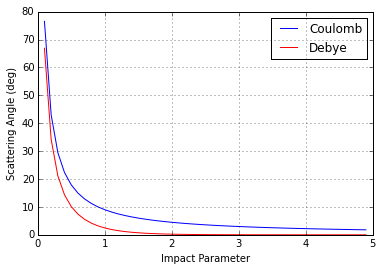

In [52]:
deg      = 180/sp.pi
plt.plot(b_range,TwoBody_theta_range*deg,'b-', label = 'Coulomb')
plt.plot(b_range,Debye_theta_range*deg,'r-',label = 'Debye')
plt.grid(True)
plt.legend()
plt.xlabel('Impact Parameter')
plt.ylabel('Scattering Angle (deg)')
#plt.savefig('c:/Users/Conrad/Pictures/Scattering_Angle_v_b.jpg')

In [10]:
timespan             = np.arange(0,20,0.001)
b                    = 0.1
x0                   = 30
s0                   = [-1.0*x0,b,0,2.25,0,0]
params               = {'alpha':-0.4, 'R':0.5}
soln_Debye           = ode(Debye,s0,timespan,args=(params,),rtol=1e-8,atol=1e-10)
Energy_D, L_D, Ecc_D = Debye_conserved_quantities(soln_Debye,params)
ex_D                 = -Ecc_D[0,0]
ey_D                 = -Ecc_D[0,1]
r_D                  = sp.sqrt( (soln_Debye[:,0:3]*soln_Debye[:,0:3]).sum(axis=1) )

In [11]:
timespan             = np.arange(0,20,0.001)
b                    = 0.1
x0                   = 30
s0                   = [-1.0*x0,b,0,2.25,0,0]
params               = {'alpha':-0.4, 'R':0.5}
soln_TwoBody         = ode(TwoBody,s0,timespan,args=(params,),rtol=1e-8,atol=1e-10)
Energy_T, L_T, Ecc_T = TwoBody_conserved_quantities(soln_TwoBody,params)
ex_T                 = -Ecc_T[0,0]
ey_T                 = -Ecc_T[0,1]
r_T                  = sp.sqrt( (soln_TwoBody[:,0:3]*soln_TwoBody[:,0:3]).sum(axis=1) )

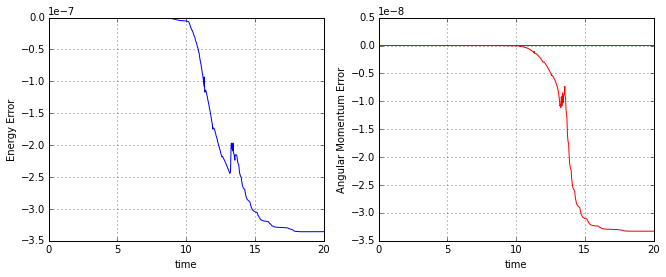

In [16]:
fig           = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(timespan,Energy_D-Energy_D[0])
ax1.set_xlabel('time')
ax1.set_ylabel('Energy Error')
ax1.grid(True)
ax2 = fig.add_subplot(122)
ax2.plot(timespan,L_D[:,0]-L_D[0,0],timespan,L_D[:,1]-L_D[0,1],timespan,L_D[:,2]-L_D[0,2])
ax2.set_xlabel('time')
ax2.set_ylabel('Angular Momentum Error')
ax2.grid(True)
fig.subplots_adjust(left=-0.5)
#fig.savefig('c:/Users/Conrad/Pictures/Conserved_Quantities_Debye.jpg')

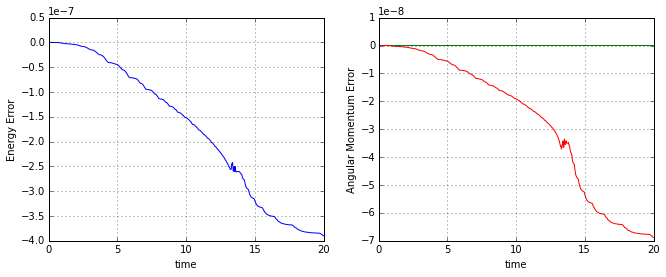

In [13]:
gig           = plt.figure()
ax3 = gig.add_subplot(121)
ax3.plot(timespan,Energy_T-Energy_T[0])
ax3.set_xlabel('time')
ax3.set_ylabel('Energy Error')
ax3.grid(True)
ax4 = gig.add_subplot(122)
ax4.plot(timespan,L_T[:,0]-L_T[0,0],timespan,L_T[:,1]-L_T[0,1],timespan,L_T[:,2]-L_T[0,2])
ax4.set_xlabel('time')
ax4.set_ylabel('Angular Momentum Error')
ax4.grid(True)
gig.subplots_adjust(left=-0.5)
#gig.savefig('c:/Users/Conrad/Pictures/Conserved_Quantities_Coulomb.jpg')

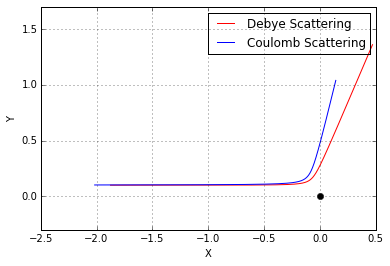

In [14]:
plt.plot(soln_Debye[12500:14000,0],soln_Debye[12500:14000,1],'r-',label='Debye Scattering')
plt.plot(0,0,'ko')
plt.plot(soln_TwoBody[12500:14000,0],soln_TwoBody[12500:14000,1],'b-',label='Coulomb Scattering')
plt.grid(True)
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
#plt.savefig('c:/Users/Conrad/Pictures/Scattering_comparison.jpg')